In [1]:
import os
import random
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from mmcv import Config
import mmcv
from mmdet.datasets.utils import get_dataset
from PIL import Image


image_dir = 'data/dataset/images'
filenames = os.listdir(image_dir)

In [19]:
mean=[123.675, 116.28, 103.53]
std=[58.395, 57.12, 57.375]

cfg = Config.fromfile('configs/baseline.py')
ds = get_dataset(cfg.data.train)

In [239]:
a = ds[0]
img = a['img'].data.numpy()
gt_bboxes = a['gt_bboxes'].data.numpy()
gt_labels = a['gt_labels'].data.numpy()

img = np.transpose(img, (1, 2, 0))
img = img * std + mean
img = img.astype('uint8')

In [16]:
gt_bboxes

tensor([[518.5678,  83.0920, 723.5422, 256.5320],
        [404.6931,  88.3478, 522.0716, 265.2916],
        [173.4399, 125.1381, 338.1202, 196.9667]])

In [14]:
img.shape

(3, 416, 704)

In [210]:
img = mmcv.imread('/home/arias/Pictures/27fcdd81205ef28fcc2febcd57e9b65a167.png')
gt_bboxes = np.array([[50.5, 60, 100, 200],
                      [350, 270, 456, 342]])
gt_labels = np.array([0, 1])

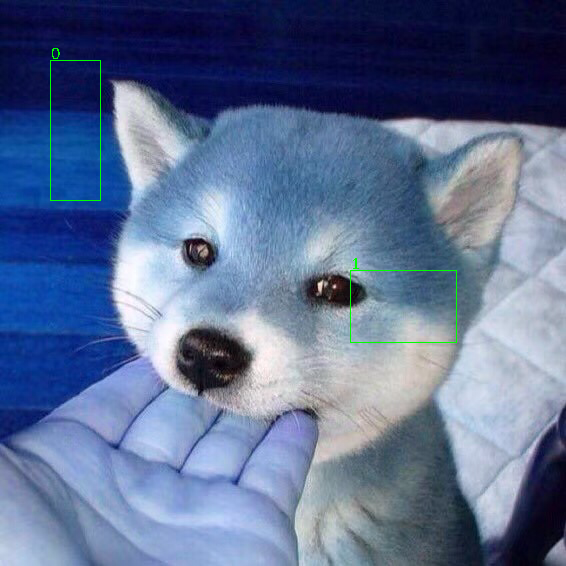

In [211]:
mmcv.imshow_det_bboxes(Image.fromarray(img), gt_bboxes, gt_labels)

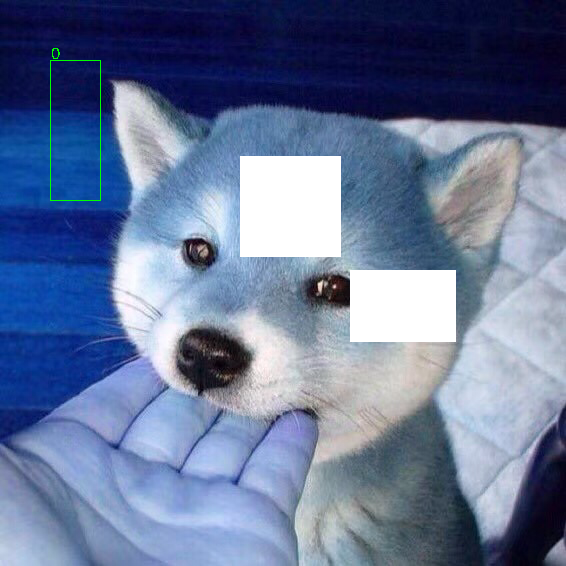

In [238]:
def _cutout_bboxes(img, gt_bboxes, gt_labels):
    # if gt_bboxes has less than 1 bbox, then just return, no cutout will be operated
    if gt_bboxes.shape[0]<=1:
        return img, gt_bboxes, gt_labels
    cutout_index = random.randint(0, gt_bboxes.shape[0]-1)
    cutout_bbox = gt_bboxes[cutout_index, :].astype('int')
    x1, y1, x2, y2 = cutout_bbox
    cutout_img = img.copy()
    cutout_img[y1:y2, x1:x2, :] = 255
    
    cutout_gt_bboxes = np.delete(gt_bboxes, cutout_index, axis=0)
    cutout_gt_labels = np.delete(gt_labels, cutout_index, axis=0)
    return cutout_img, cutout_gt_bboxes, cutout_gt_labels


def _cutout_background(img, gt_bboxes, gt_labels):
    bg_bbox = random_background_bbox(img.shape, fg_bboxes=gt_bboxes, bg_bbox_shape=(100, 100), n=1)
    if bg_bbox is None:
        return img, gt_bboxes, gt_labels
    x1, y1, x2, y2 = bg_bbox
    img = img.copy()
    img[y1:y2+1, x1:x2+1, :] = 255
    return img, gt_bboxes, gt_labels


def cutout(img, gt_bboxes, gt_labels):
    """
    Args:
        img(numpy.ndarray): (h, w, c)
        gt_bboxes(numpy.ndarray): (m, 4), (x1, y1, x2, y2)
        gt_labels(numpy.ndarray): (m, )
    """
    # 0.5 probability to do cutout
#     if random.random()>=0.5:
#         return img, gt_bboxes, gt_labels
    # foregroound means cutout gt_bboxes
    # background means cutout background
    # both means cutout one background and one foreground
    coutout_types = ['foreground', 'background', 'both']
    cutout_type = random.choice(coutout_types)
    if cutout_type=='background':
        return _cutout_background(img, gt_bboxes, gt_labels)
    elif cutout_type=='foreground':
        return _cutout_bboxes(img, gt_bboxes, gt_labels)
    else:
        img, gt_bboxes, gt_labels = _cutout_background(img, gt_bboxes, gt_labels)
        return _cutout_bboxes(img, gt_bboxes, gt_labels)

cuted_img, cuted_gt_bboxes, cuted_gt_labels = cutout(img, gt_bboxes, gt_labels)
mmcv.imshow_det_bboxes(Image.fromarray(cuted_img), cuted_gt_bboxes, cuted_gt_labels)

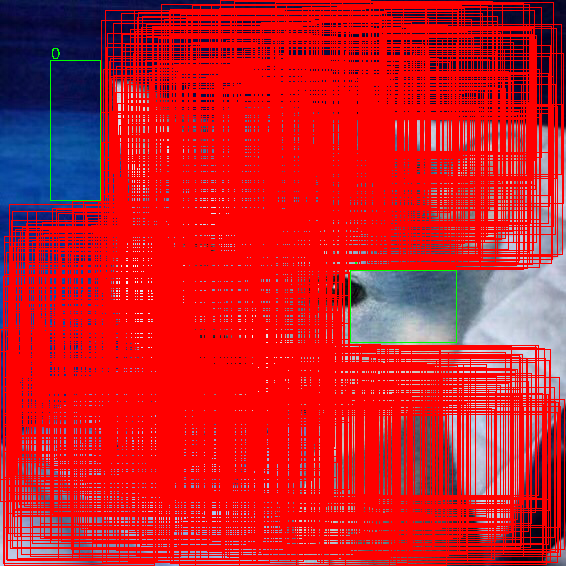

In [207]:
def mesh_coordinate(x, y):
    x = np.arange(x)
    y = np.arange(y)
    xx = np.tile(x, len(y))
    yy = np.repeat(y, len(x))
    coords = np.stack([xx, yy], axis=-1)
    return coords


def random_background_bbox(img_shape, fg_bboxes, bg_bbox_shape, n=1):
    """
    Args:
        img_shape(tuple or list): (h, w, ...)
        fg_bboxes(list of list or numpy.ndarray): (m, 4), (x1, y1, x2, y2)
        bg_bbox_shape(tuple or list): (h, w)
    """
    img_h, img_w = img_shape[:2]
    bg_h, bg_w = bg_bbox_shape
    mask = np.ones(shape=(img_h, img_w), dtype='uint')
    for bbox in fg_bboxes:
        x1, y1, x2, y2 = bbox.astype('int')
        left_border = max(x1-bg_w, 0)
        right_border = x2
        top_border = max(y1-bg_h, 0)
        bottom_border = y2
        mask[top_border:bottom_border+1, left_border:right_border+1] = 0
    # handler image border
    mask[-bg_h:, :] = 0
    mask[:, -bg_w:] = 0

    coords = mesh_coordinate(img_w, img_h)
    valid_flag = mask.reshape(-1)
    valid_indexes = np.nonzero(valid_flag)[0]
    
    if valid_indexes.shape[0]==0:
        return None
    bg_indexes = np.random.choice(valid_indexes, size=n)
    bg_coords = coords[bg_indexes, :]
    x1, y1 = bg_coords[:, 0], bg_coords[:, 1]
    bg_coords = np.stack([x1, y1, x1+bg_w, y1+bg_h], axis=-1)
    if n==1:
        return bg_coords[0]
    else:
        return bg_coords

bg_bbox = random_background_bbox(img.shape, gt_bboxes, (150, 150), n=1000)

gt_img = mmcv.imshow_det_bboxes(Image.fromarray(img), gt_bboxes, gt_labels)
mmcv.imshow_bboxes(gt_img, bg_bbox, colors='red')